**INTRODUCTION TO CONVOLUTIONAL NEURAL NETWORKS**

**Convolutional Neural Networks are used for image classification due to several reasons:**

1) They reduce the number of input nodes to the Neural Network.

2) They tolerate small changes to where the pixels are on the image because they can capture spatial information (information about how different pairs of pixels are located in the image relative to each other). With a fully flattened array as the input to a fully connected Neural Network this information would be lost.

3) They take advantages of correlations among pixels in complex images



**Why not use a fully connected Neural network?**

1) It would create a huge Neural Network because each pixel in the raw image would become an input to the network and would be connected with multiple nodes in the hidden layer. This would make the task of calculating weights for each input-node connection and retaining them for backpropagation very slow and expensive in terms of RAM resources.

Amini, A. (2020)

#Install and load required libraries

In [1]:
!pip install wget
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#import necessary libraries

import pandas as pd
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds
import zipfile
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import wget
import cv2
import random
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras import layers 
from keras.backend import resize_images
#from tensorflow.keras.models import load_model
import keras_tuner as kt

#Download and pre-process dataset

**How computers see images?**

Computers see images as an array or matrix of numbers. For black and white pictures they see a single array or matrix of pixel values of size m x n (m being the number of columns or image width in pixels and n being the number of rows or image height in pixels). For coloured images they see an array of size m x n x 3, with one array for each color in the RGB scale.

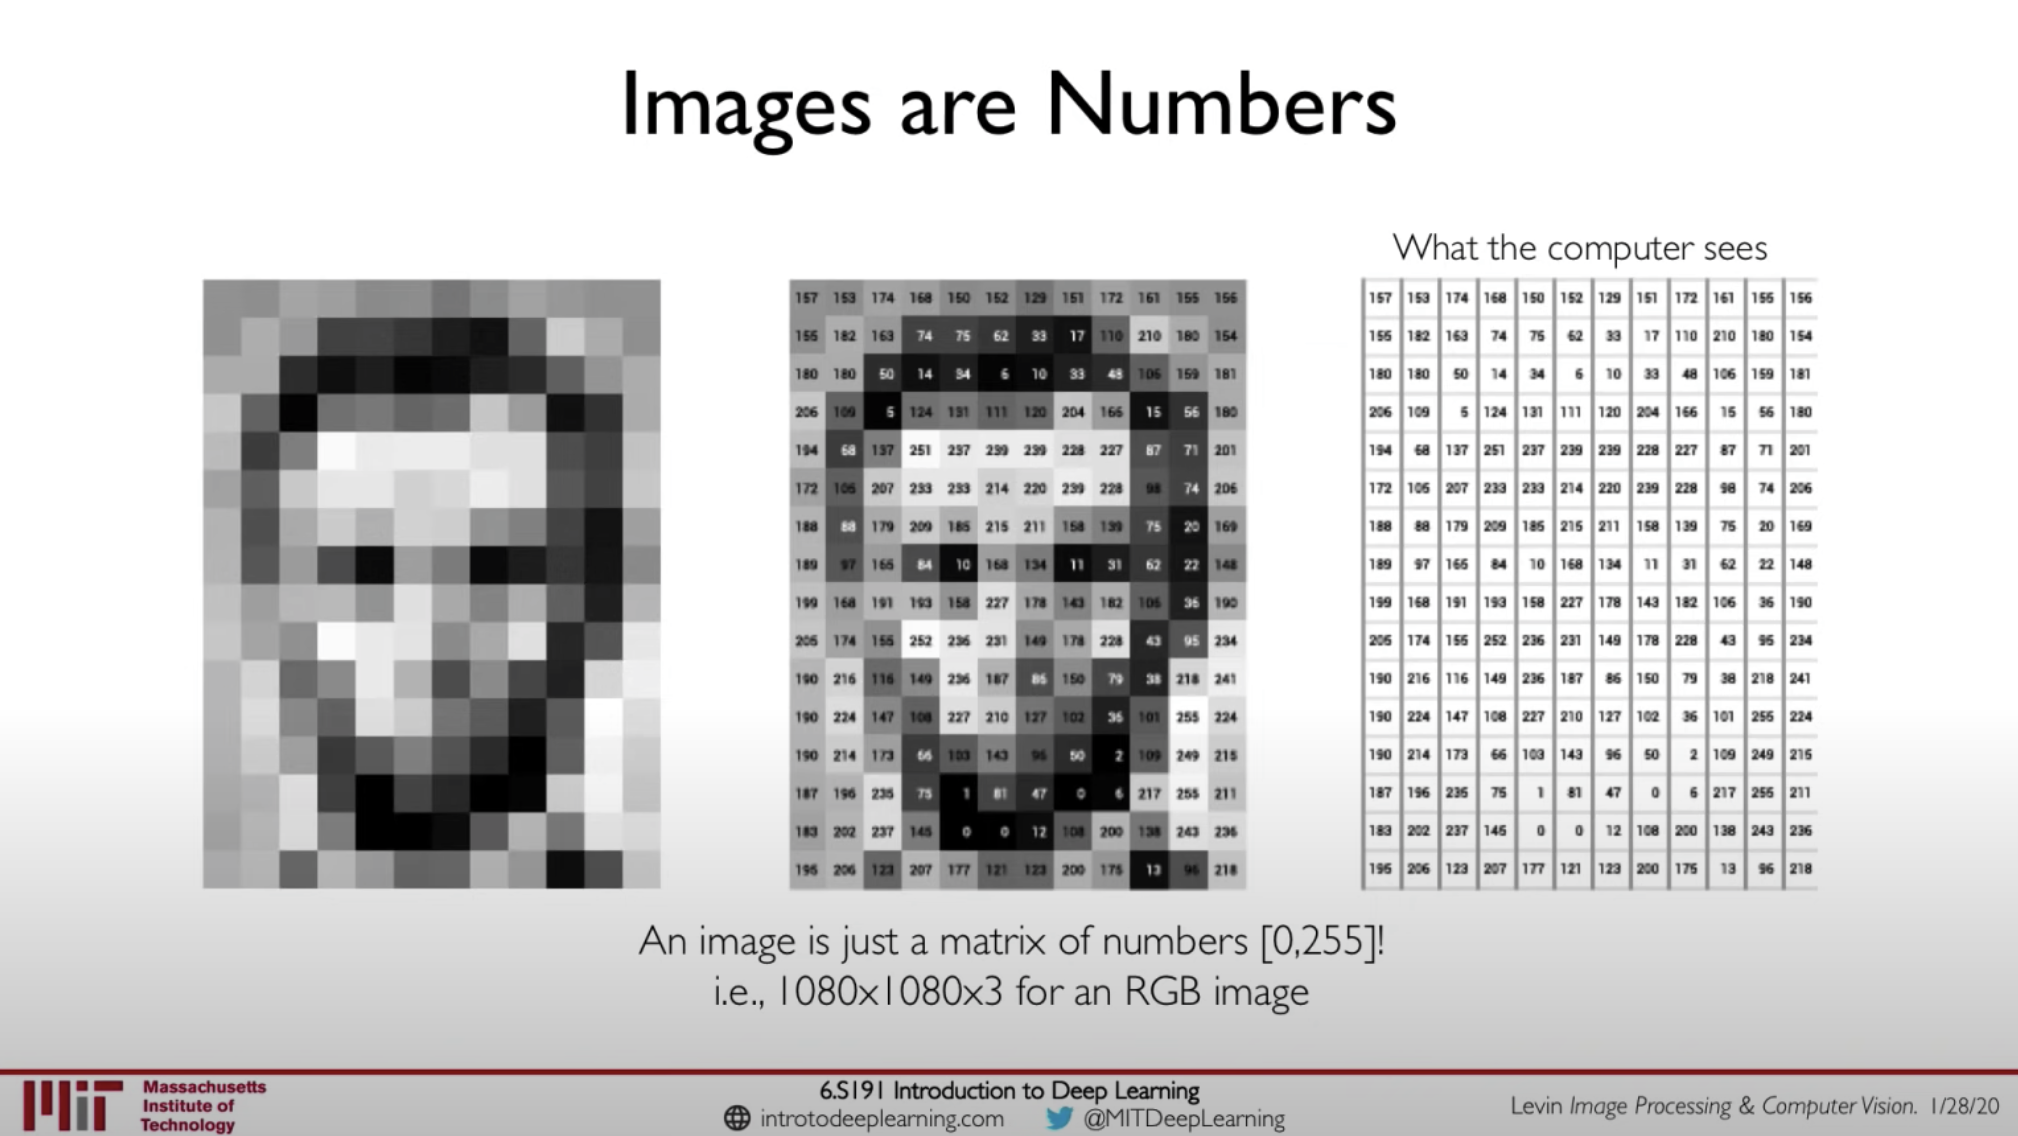

Image source: Amini, A. (2020)




In [3]:
#define a function to download an unzip the file 
#from https://stackoverflow.com/questions/49685924/extract-google-drive-zip-from-google-colab-notebook

def download_unzip(url):
  file_name = wget.download(url)
  zip_ref = zipfile.ZipFile(file_name, 'r')
  zip_ref.extractall()
  zip_ref.close() 
  print("Dataset downloaded and unzipped in the current directory")


In [4]:
#download and unzip content using the download_unzip function

download_unzip("https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip")

Dataset downloaded and unzipped in the current directory


In [5]:
# define image size and base directory with the dataset 

img_width = 180
img_height = 180
base_dir = 'cats_and_dogs_filtered'



In [6]:
#explore data within base directory

print(os.listdir(base_dir))

['validation', 'vectorize.py', 'train']


In [7]:
# explore each of the subdirectories

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

print(os.listdir(train_dir))
print(os.listdir(validation_dir))

['cats', 'dogs']
['cats', 'dogs']


In [8]:
#continue exploing directories / files within each subdirectory

train_cats_dir = os.path.join(train_dir, 'cats')

train_dogs_dir = os.path.join(train_dir, 'dogs')

val_cats_dir = os.path.join(validation_dir, 'cats')

val_dogs_dir = os.path.join(validation_dir, 'dogs')

#explore file names within directories

train_cat_fnames = os.listdir(train_cats_dir)
train_cat_fnames.sort()
print(train_cat_fnames[:5])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:5])

val_cat_fnames = os.listdir(val_cats_dir)
val_cat_fnames.sort()
print(val_cat_fnames[:5])

val_dog_fnames = os.listdir(val_dogs_dir)
val_dog_fnames.sort()
print(val_dog_fnames[:5])


['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg']
['cat.2000.jpg', 'cat.2001.jpg', 'cat.2002.jpg', 'cat.2003.jpg', 'cat.2004.jpg']
['dog.2000.jpg', 'dog.2001.jpg', 'dog.2002.jpg', 'dog.2003.jpg', 'dog.2004.jpg']


In [9]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(val_cats_dir)))
print('total validation dog images:', len(os.listdir(val_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [10]:
#define function to transform the data 

img_width=180
img_height=180
directories = [train_cats_dir, train_dogs_dir, val_cats_dir, val_dogs_dir]

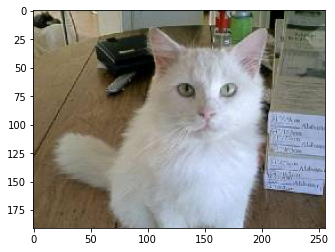

In [11]:
#print a random image

random_image = random.choice(train_cat_fnames)
image = load_img(os.path.join(train_cats_dir, random_image))
plt.imshow(image)



#Pre-process images manually

In order to pass the images to a CNN for processing, we first need to convert them from image format to an array of pixel values as explained previously.

In [12]:
#try to resize random image

image = cv2.imread(os.path.join(train_cats_dir, random_image), cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (180, 180), interpolation = cv2.INTER_AREA)
image = image.astype('float32')
image /= 255
img_data_array = image
class_name = random_image.split('.')[0]

print(img_data_array.shape)
print(class_name)

(180, 180, 3)
cat


In [13]:
#define a function to transform all images in the directory
#classify images and labels into train and validation groups

def transform_dataset(base_dir):
  img_data_array_train = []
  class_name_train = []
  img_data_array_val = []
  class_name_val = []

  for dir1 in os.listdir(base_dir):
    if dir1 == 'train': #first transform images in the train directory
      for dir2 in os.listdir(os.path.join(base_dir, dir1)):
        for file in os.listdir(os.path.join(base_dir, dir1, dir2)):
          image_path = os.path.join(base_dir, dir1, dir2, file) #find the path 
                                                                #to the image
          image = cv2.imread(image_path, cv2.COLOR_BGR2RGB) #read the 
                                                            #actual image
          try:
            image = cv2.resize(image, (img_width, img_height),
                               interpolation = cv2.INTER_AREA) #resize the image
            image = np.array(image) #transform image to numpy array
            image = image.astype('float32') #transform elements to float32
            image /= 255 #scale array values to between 0 and 1
            img_data_array_train.append(image) # append transformed image to
                                               # train list 
            class_name_train.append(file.split('.')[0]) #append class to list
          except:
            break
        #return img_data_array_train, class_name_train
    if dir1 == 'validation': #repeat the same process for images in validation
      for dir2 in os.listdir(os.path.join(base_dir, dir1)):
        for file in os.listdir(os.path.join(base_dir, dir1, dir2)):
          image_path = os.path.join(base_dir, dir1, dir2, file)
          image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
          try:
            image = cv2.resize(image, (img_width, img_height), 
                                      interpolation = cv2.INTER_AREA)
            image = np.array(image)
            image = image.astype('float32')
            image /= 255
            img_data_array_val.append(image)
            class_name_val.append(file.split('.')[0])
          except:
            break
        #return img_data_array_val, class_name_val
  return img_data_array_train, class_name_train, img_data_array_val, class_name_val


In [14]:
# extract the image array and class name

img_data_array_train, class_name_train, img_data_array_val, class_name_val = transform_dataset(base_dir)

In [15]:
#create dictionary with key-value pairs for each of the classes (cats and dogs)

target_dict_train={k: v for v, k in enumerate(np.unique(class_name_train))}
target_dict_train

{'cat': 0, 'dog': 1}

In [16]:
#build single list with the encoding of each class

target_train = [target_dict_train[class_name_train[i]] for i in range(len(class_name_train))]

In [17]:
#check that that list contains all the examples we had at the beggining (1000 x 2)

count_0 = target_train.count(0)

count_1 = target_train.count(1)

print(count_0)
print(count_1)


1000
1000


In [18]:
#repeat the same process for the classes in the validation dataset 

target_dict_val={k: v for v, k in enumerate(np.unique(class_name_val))}
target_dict_val

{'cat': 0, 'dog': 1}

In [19]:
#create a target_val list of encoded class values

target_val = [target_dict_val[class_name_val[i]] for i in range(len(class_name_val))]

#Define the first CNN model

**Parts of a Convolutional Neural Network:**

Input layer: the first layer of a CNN will have the same shape as the dataset we're feeding. In this case we will have an input layer of shape 180 x 180 x 3 becaused we resized all images in the dataset to 180x180 and they are images in colour so they have 3 layers one for each colour in RGB.

Convolutional layer: "convolution" it's a process by which additional features are extracted from each image. The process works by defining a subsection of the image (a patch) and then analysing the image by looking at it in different patches. For example, an image of 12px x 12px could be analysed in 9 patches of 4px x 4px by shifting the patch 4px to the right or down each time. 

Every time this filter of 4x4 runs through the entire image, a different set of weights can be applied to extract local features from each sample. In our example we would take a patch of 4x4 from the original 12x12 image, and we would compute the "Dot product" between each pixel value in the patch with the value of the weight in the equivalent position in the filter. We would do this for all patches and then run this process several times with different weights in the filter. This allows us to extract multiple features from each image. (Starmer, 2021)

The results of "convoluting" (i.e calculating the Dot Product) the original image with each of the filters are stored in separate arrays which are called "feature maps". There's going to be as many feature maps as number of filters.

Feature maps are then run through an activation function, typically a ReLu activation function, to create a bigger contrast between positive values and negative values (that happens because ReLu converts negative values to 0 whilst keeping positive values the same).

Pooling layer: The next step is to run each of the feature maps through the process of pooling. Pooling allows us to reduce the number of features that are eventually fed to the Neural Network by either selecting the "maximum" value or the "mean" value of different patches of the feature maps. 

Neural Network: deep learning is a type of machine learning that involves algorithms with a structure inspired on the function of the brain. Neural networks are a type of deep learning algorithms that have an input layer with several nodes, an output layer with the final prediction and normally one or several hidden layers. For each hidden node the algorithm will calculate an output based on the input layers and the defined activation function. It will do this repetitively across as many layers as defined in the design phase until it reaches a final outcome in the output layer. Neural networks can become very good at understanding the relationship between all the features and can work well establishing relationships between non-linear variables.

Output: the last layer in the network will contain in this case two nodes, one for each of the classes we're trying to predict. It will use a "softmax" activation function so that output values are normalized and each class is given a probability (i.e. 90% "cat" and 10% "dog). An alternative to the shape of the output layer for this classification problem would be to have one single node and apply a "sigmoid" activation function. A sigmoid activation function would convert large values to 1 and low values to 0, thus providing the binary output needed for this binary classification exercise.

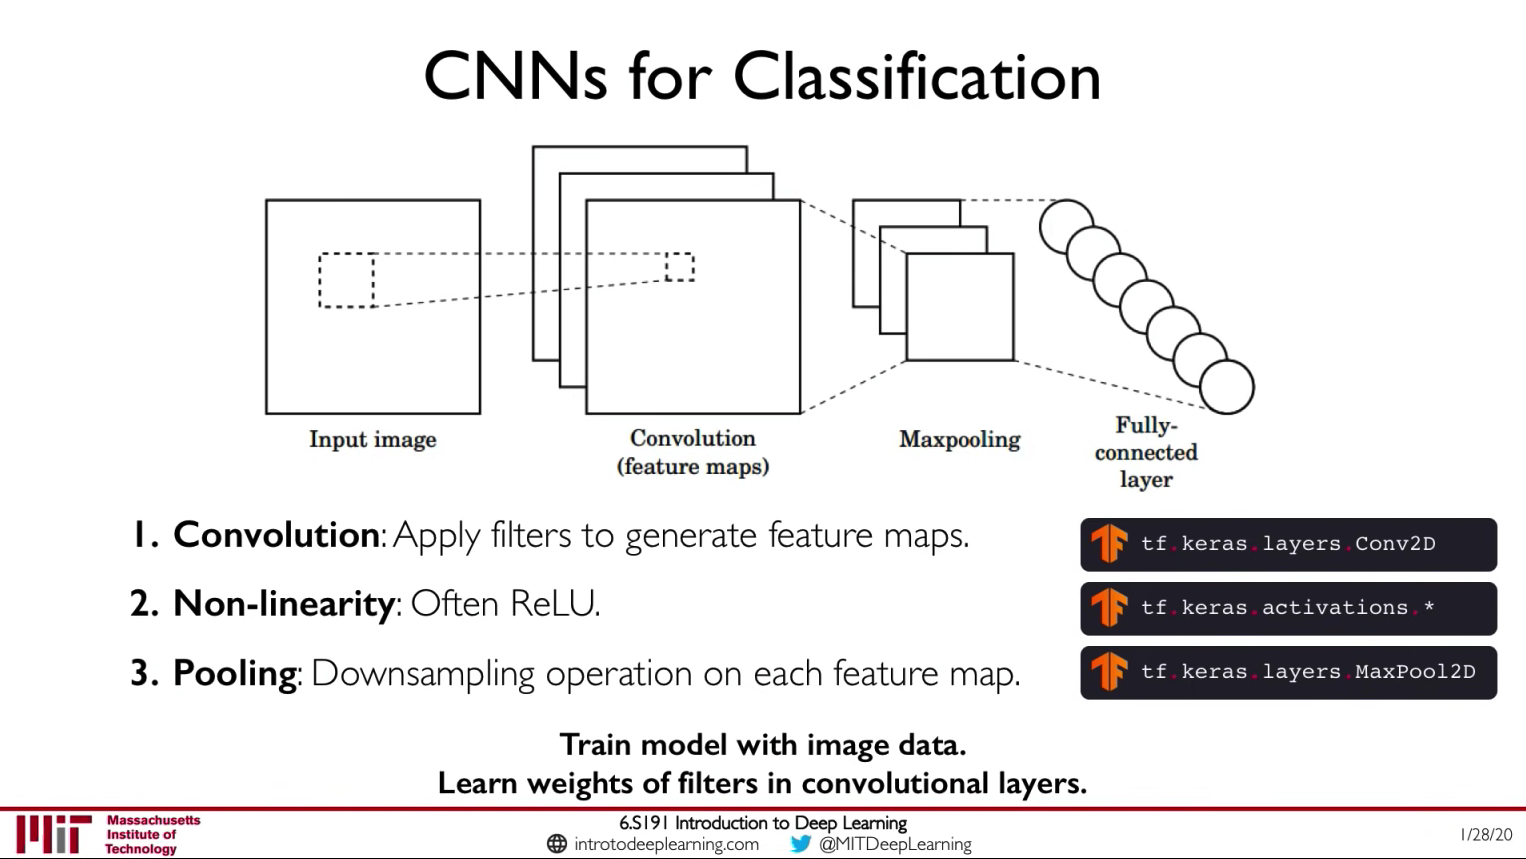

Image Source: Amini, A. (2020)

In [20]:
#define a Convolutional Neural Network architechture

model=tf.keras.Sequential(
        [
            #input layer with the shape of the image (px width, height and 3 layers one for each RGB color)
            tf.keras.layers.InputLayer(input_shape=(img_width,img_height, 3)), 
            #first convolutional layer with 64 filters
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, activation='relu'),
            #batch normalization layer 
            tf.keras.layers.BatchNormalization(),
            #max pooling to summarise the results of the first layer of feature extraction
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            #second convolutional layer, again with 64 filters 
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            #third convolutional layer, this time with 128 filters 
            tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            #fourth convolutional layer, again with 128 filters 
            tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            #A layer to flaten the results of all images into a single vector, which will be the input to our dense layer 
            tf.keras.layers.Flatten(),
            #A first dense layer with 256 nodes and relu activation 
            tf.keras.layers.Dense(256, activation='relu'),
            #another layer of batch normalization
            tf.keras.layers.BatchNormalization(),
            # A dropout layer to reduce overfitting the traning data
            tf.keras.layers.Dropout(0.5),
            # A second dense layer, this time with 512 nodes
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            # A final output layer with 2 nodes (one for each class) and a softmax activation
            tf.keras.layers.Dense(2, activation="softmax")
        ])

#compile the model
#define the optimizer to minimise the cost function, along with a learning rate of 0.0001
#define the loss function to use, in this case we use "sparse categorical crossentropy" because we've transformed class labels into integers
#if class labels had been one-hot encoded we would use "categorical crossentropy"
#the loss function for both is the same, the usage will depend on how the data labels are loaded 
#define the metric of success

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


CNN architecture and hyperparameter values:

The CNN architechture above uses four convolutional layers and one dense layer. The number of filters in the convolutional layers grows as we progress through the CNN. This allows the network to start with picking up a smaller number of simpler features and find new ways of combining them later on with a higher number of filters. (Géron, A 2019)

After each convolutional layer we have a Batch Normalization layer which normalises the the learnings from the previous layer. Batch normalization layers help improve accuracy and increase the speed of learning. Though they work well it is not well understood why they do. (Bjorck, J. et al 2018)

Once we've run all the convolutional layers, including batch normalisation and max pooling, we have to flatten to results into a 1-dimensional vector which allows us to input the result into the dense network.

In this case we've chosen to run one single fully connected layer. Generally speaking the only way of finding out the optimal number of layers and nodes for neural networks is by trial an error. Some authors believe that "greater depth [of layers] does seem to result in better generalization for a wide variety of tasks." (Goodfellow et al., 2016). But at the same time, a high number of layers and nodes increases the number of parameters to train, which increaes training time and resources and can lead to overfitting. After previous trials, the author decided it was better to use one single fully connected layer. As for the number of nodes, as previously mentioned, the optimal number is just another parameter to optimise. However, since this CNN uses one single hidden layer only it is preferred to make this layer fairly large, using up to 512 nodes. This is so that the network doesn't lose predictive power by having only one layer (Brownlee, 2018)

Almost every layer in the CNN has one or more hyperparameters that can be configured to change the performance:

- Convolutional layer hyperparameters include number of filters, filter size, strides and activation function. 

- Max pooling hyperparameter includes the pool size.

- Dense layer hyperparameters include the number of nodes as well as the activation function. 

- The dropout layer includes the percentage value of nodes that are discarded at every layer.

Lastly, in order to calculate the weights for the network an optimiser function with a specific learning rate and a loss function have to be defined.

In this particular case we've selected RMSprop as optimiser to minimise the cost function. Generally speaking adaptive optimisers such as RMSprop work well with sparse data such as images and they allow offer the possibility of not having to fine-tune the optimiser learning rate (since the optimiser can adapt it by design). (Giordano, 2020)

The loss function allows the network to compute the loss between true labels and predictions. The shape of the network will define the type of loss function that can be used. In this particular case, since we've opted to have two output nodes (one for each class) the author has chosen to use Sparse Categorical Crossentropy. If the network had one node in the output layer we would have used Categorical Crossentropy instead.

In [21]:
#fit the model we just created and capture the results in the "history variable"

history_v1 = model.fit(x=np.array(img_data_array_train, np.float32), 
                    y=np.array(list(map(int,target_train)), np.float32), #convert training data to an array of floats training data
                    epochs=50, #number of epochs to train on
                    validation_data=(np.array(img_data_array_val, np.float32),
                                     np.array(list(map(int,target_val)), np.float32)) #validation data
                    )

Epoch 1/50
63/63 [==============================] - 9s 40ms/step - loss: 1.1082 - accuracy: 0.5485 - val_loss: 0.7816 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 2s 25ms/step - loss: 1.0148 - accuracy: 0.5785 - val_loss: 1.1288 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 2s 25ms/step - loss: 0.9105 - accuracy: 0.6210 - val_loss: 1.2770 - val_accuracy: 0.5000
Epoch 4/50
63/63 [==============================] - 2s 25ms/step - loss: 0.8884 - accuracy: 0.6195 - val_loss: 1.4728 - val_accuracy: 0.5000
Epoch 5/50
63/63 [==============================] - 2s 26ms/step - loss: 0.8458 - accuracy: 0.6540 - val_loss: 1.4292 - val_accuracy: 0.5000
Epoch 6/50
63/63 [==============================] - 2s 28ms/step - loss: 0.8210 - accuracy: 0.6485 - val_loss: 1.5779 - val_accuracy: 0.5010
Epoch 7/50
63/63 [==============================] - 2s 31ms/step - loss: 0.8005 - accuracy: 0.6775 - val_loss: 1.6192 - val_accuracy: 0.5070
Epoch 8/50
63

In [22]:
#define a function to show the history of loss and accuracy by epoch

def show_history(history_v):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history_v.epoch, history_v.history["loss"], label="Train loss")
    ax[0].plot(history_v.epoch, history_v.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history_v.epoch, history_v.history["accuracy"], label="Train accuracy")
    ax[1].plot(history_v.epoch, history_v.history["val_accuracy"], label="Validation accuracy")
    ax[0].legend()
    ax[1].legend()
    ax[0].grid(True)
    ax[1].grid(True)
    

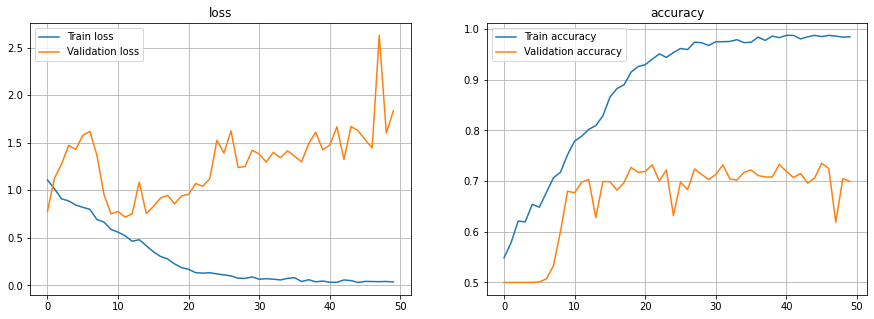

In [23]:
show_history(history_v1)

#Second CNN model including data augmentation and regularization

**DATA AUGMENTATION:** it's a technique used when training CNNs to produce more training samples from a given dataset. There are multiple data augmentation techniques but the basic idea for each of them is to produce different training samples by making small changes to the original images. For example, an image may be rotated on a certain angle or flipped horizontally thus changing the actual position of the pixels in the array. 

**REGULARIZATION:** it's a technique used in machine learning to help reduce overfitting in the training data. It achieves so by adding a "regularization" parameter to the loss function. This regularization parameter in the loss function reduces the weight of each of the features captured by the network. In convolutional layers with a high number of filters or in dense layers with a high number of nodes this helps decrease overfiting since it removes weight from each of the filters/nodes in the layer.

In [24]:
#try to run the same model but adding a few image augmentation layers in the model 
#as well as regularization parameters and removing one dense layer

model_v2=tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(img_height,img_width, 3)),
            #first data augmentation layer which flips the image horizontally
            tf.keras.layers.RandomFlip("horizontal"),
            #second data augmentation layer which rotates the image at a positive angle
            tf.keras.layers.RandomRotation(0.1),
            #After image augmentation we continue with the same structure of convolutional layers we had before.
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            #Second convolutional layer
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            #Third convolutional layer, this time though we add an L2 regularization parameter with a lambda value of 0.01
            tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            #Fourth convolutional layer, again we add an L2 regularization parameter to help reduce overfitting
            tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            #Flatten the output of convolutional layers into a single vector
            tf.keras.layers.Flatten(),
            #create a single dense layer of 512 nodes
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(2, activation="softmax")
        ])

#compile the model with the same optimizer, loss function and success metric

model_v2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [25]:
#define callbacks to save the model at each iteration

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("./model_v2_logs/save_at_{epoch}.h5"),
]


In [26]:
#fit the model variation and capture the results in the "history variable"

history_v2 = model_v2.fit(x=np.array(img_data_array_train, np.float32), 
                    y=np.array(list(map(int,target_train)), np.float32), 
                    epochs=100,
                    callbacks=callbacks,
                    validation_data=(np.array(img_data_array_val, np.float32),
                                     np.array(list(map(int,target_val)), np.float32))
                    )

Epoch 1/100
63/63 [==============================] - 4s 37ms/step - loss: 3.0372 - accuracy: 0.5705 - val_loss: 2.8181 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 2s 27ms/step - loss: 2.8721 - accuracy: 0.6200 - val_loss: 2.8676 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 2s 28ms/step - loss: 2.8302 - accuracy: 0.6380 - val_loss: 2.9577 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 2s 27ms/step - loss: 2.8046 - accuracy: 0.6460 - val_loss: 3.0743 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 2s 28ms/step - loss: 2.7466 - accuracy: 0.6545 - val_loss: 3.2368 - val_accuracy: 0.5010
Epoch 6/100
63/63 [==============================] - 2s 28ms/step - loss: 2.6714 - accuracy: 0.6935 - val_loss: 2.9945 - val_accuracy: 0.5140
Epoch 7/100
63/63 [==============================] - 2s 28ms/step - loss: 2.6638 - accuracy: 0.6800 - val_loss: 2.9578 - val_accuracy: 0.5450
Epoch 

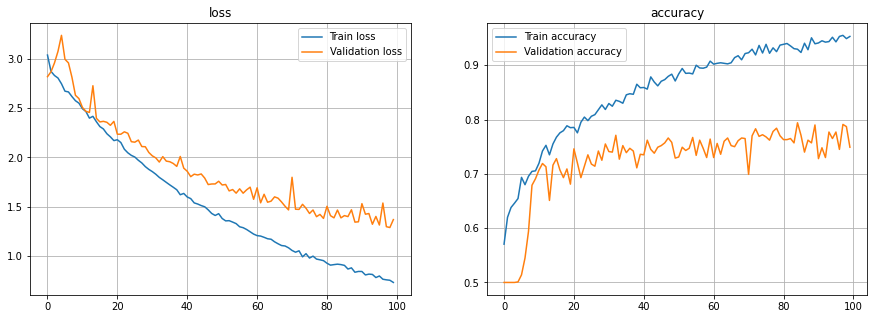

In [27]:
#display results 

show_history(history_v2)

#Third CNN model adding early stopping and learning rate reduction

In [28]:
#run the same model but adding callbacks to reduce learning rate on plateau
#increasing learning rate in the model to 1e-3 beacause it will decrease gradually as accuracy rates start to plateau

#try to run a quick model

model_v3=tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(img_height,img_width, 3)),
            #Data augmentation layers
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            #Convolutional layer 1
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            #Convolutional layer 2
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            #Convolutional layer 3
            tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            #Convolutional layer 4
            tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            #Flatten results into a single vector
            tf.keras.layers.Flatten(),
            #Dense layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(2, activation="softmax")
        ])

#compile the new model

model_v3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [29]:
# define an "early stopping" variable to stop running the network if accuracy hasn't increased in 10 epochs

earlystop = EarlyStopping(patience=10)


In [30]:
# define another callback to reduce the learning rate when validation accuracy starts to plateau
# this might help minimise the loss function when the network has been updating weights for some time
# everytime values are forward and backward propagated the rate of change to reduce the loss function might have to be smaller 
# reducing the learning rate will achieve that 

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', #success metric to monitor to understand if learning rate should be reduced
                                            patience=2, #number of epochs with no improvements before learning rate is reduced
                                            verbose=1, 
                                            factor=0.5, #each time we reduce the learning rate we reduce it by half
                                            min_lr=0.00001) #learning rate wil be reduced to a minimum of 1e-5

In [31]:
#define a callback variable including the early stopping, learning rate reduction as well as the variable to save the model at every epoch

callbacks = [earlystop, learning_rate_reduction,tf.keras.callbacks.ModelCheckpoint("./model_v3_logs/save_at_{epoch}.h5")]


In [32]:
#fit the model 

history_v3 = model_v3.fit(x=np.array(img_data_array_train, np.float32), 
                    y=np.array(list(map(int,target_train)), np.float32), 
                    epochs=50,
                    validation_data=(np.array(img_data_array_val, np.float32),
                                     np.array(list(map(int,target_val)), np.float32)),
                    callbacks=callbacks
                    )

Epoch 1/50
63/63 [==============================] - 4s 38ms/step - loss: 3.0468 - accuracy: 0.5830 - val_loss: 2.7292 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/50
63/63 [==============================] - 2s 27ms/step - loss: 2.5336 - accuracy: 0.6275 - val_loss: 2.2772 - val_accuracy: 0.4990 - lr: 0.0010
Epoch 3/50
63/63 [==============================] - 2s 28ms/step - loss: 2.1198 - accuracy: 0.6320 - val_loss: 1.8694 - val_accuracy: 0.5380 - lr: 0.0010
Epoch 4/50
63/63 [==============================] - 2s 34ms/step - loss: 1.7018 - accuracy: 0.6570 - val_loss: 2.5084 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/50
61/63 [============================>.] - ETA: 0s - loss: 1.3457 - accuracy: 0.6716
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
63/63 [==============================] - 2s 28ms/step - loss: 1.3410 - accuracy: 0.6730 - val_loss: 1.3510 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/50
63/63 [==============================] - 2s 27ms/step - loss

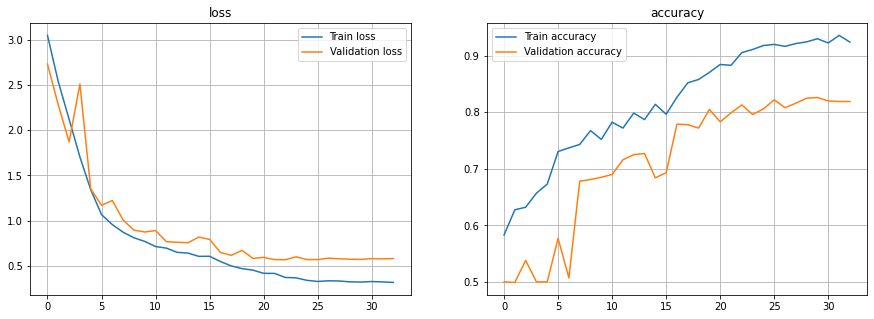

In [33]:
#display results 

show_history(history_v3)

#Fourth CNN model with mode data augmentation layers


In [34]:
#try adding a few more image augmentation layers in the model


model_v4=tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(img_height,img_width, 3)),
            #Data augmentation layers
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.2,0.2), #height an width values
            tf.keras.layers.RandomContrast(0.2), #upper and lower bound for contrast changes
            #Convolutional layer 1
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            #onvolutional layer 2
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            #onvolutional layer 3
            tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            #onvolutional layer 4
            tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            #Layer to flatten results into a single vector
            tf.keras.layers.Flatten(),
            #Dense layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(2, activation="softmax")
        ])

#compile model 

model_v4.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [35]:
# use the same callbacks as before but changing the directory to save the model at each epoch

callbacks = [earlystop, learning_rate_reduction,tf.keras.callbacks.ModelCheckpoint("./model_v4_logs/save_at_{epoch}.h5")]


In [36]:
#fit the model 

history_v4 = model_v4.fit(x=np.array(img_data_array_train, np.float32), 
                    y=np.array(list(map(int,target_train)), np.float32), 
                    epochs=50,
                    validation_data=(np.array(img_data_array_val, np.float32),
                                     np.array(list(map(int,target_val)), np.float32)),
                    callbacks=callbacks
                    )

Epoch 1/50
63/63 [==============================] - 5s 38ms/step - loss: 3.0925 - accuracy: 0.5665 - val_loss: 2.6848 - val_accuracy: 0.5010 - lr: 0.0010
Epoch 2/50
63/63 [==============================] - 2s 30ms/step - loss: 2.6630 - accuracy: 0.6010 - val_loss: 2.5243 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/50
62/63 [============================>.] - ETA: 0s - loss: 2.1535 - accuracy: 0.6169
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
63/63 [==============================] - 2s 34ms/step - loss: 2.1499 - accuracy: 0.6175 - val_loss: 2.2682 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/50
63/63 [==============================] - 2s 29ms/step - loss: 1.6986 - accuracy: 0.6670 - val_loss: 1.6511 - val_accuracy: 0.5030 - lr: 5.0000e-04
Epoch 5/50
63/63 [==============================] - 2s 29ms/step - loss: 1.4824 - accuracy: 0.6755 - val_loss: 1.6259 - val_accuracy: 0.5040 - lr: 5.0000e-04
Epoch 6/50
63/63 [==============================] - 2s 29ms/ste

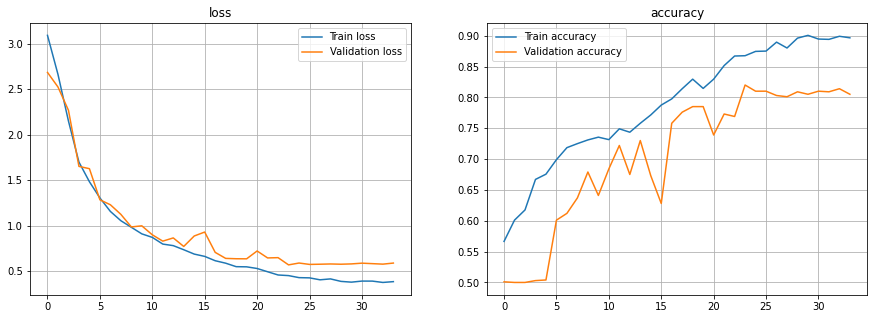

In [37]:
#display results 

show_history(history_v4)

#Repeat the same process but using TensorFlow Image Dataset from directory module for preprocessing 

In [38]:
# define the fixed variables we're going to use

batch_size = 20
img_height = 180
img_width = 180

In [39]:
#define training and validation sets directly from the directory

#image_dataset_from_directory will create a TensorFlow batched data set 
#this particular data set will have the shape of a tuple (images, labels)
#each image element will contain a tensor of shape (batch size, image_width, image_height, num_channels) 

train_ds = tf.keras.utils.image_dataset_from_directory( #create a training data set directly from the base directory
  train_dir,
  label_mode='categorical',
  image_size=(img_width, img_height),
  batch_size=batch_size)

Found 2000 files belonging to 2 classes.


In [40]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [41]:
#repeat the same process for the validation dataset

val_ds = tf.keras.utils.image_dataset_from_directory( #create a validation data set directly from the base directory
  validation_dir,
  label_mode='categorical',
  image_size=(img_width, img_height),
  batch_size=batch_size)

Found 1000 files belonging to 2 classes.


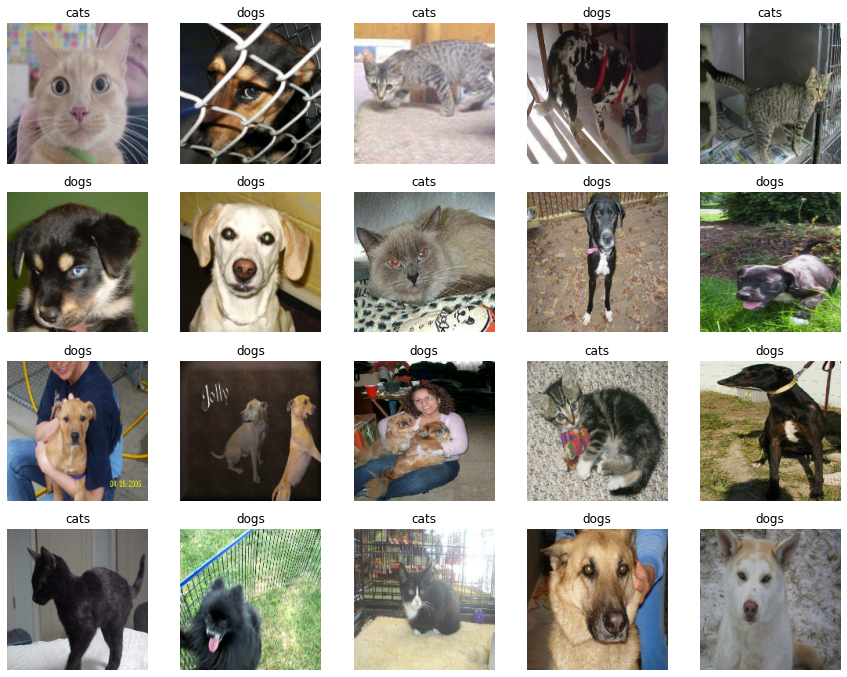

In [42]:
#visualize the data in a single batch

plt.figure(figsize=(15, 15))
class_names = train_ds.class_names
for images, labels in train_ds.take(1): #take images and labels in one batch
  for i in range(batch_size): #define for loop to plot each image and label in the batch
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

# Plotting the images
plt.show()

In [43]:
#using  TensorFlow Image Dataset from directory we can easily see data augmentation process in action 

data_augmentation = tf.keras.Sequential([                           
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])



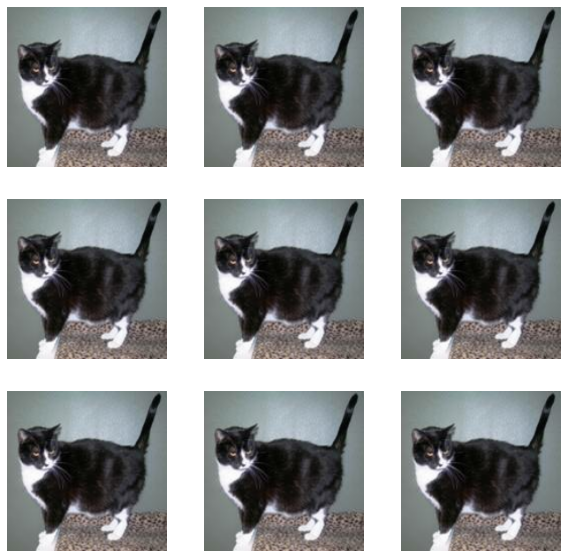

In [44]:
#see data augmentation in action

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [45]:
from keras.backend import resize_images
#run model v4 but using the tensorflow batched dataset 


model_v5=tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(img_height,img_width, 3)),
            #add a data preprocessing layer to rescale images
            tf.keras.layers.Rescaling(1./255),
            #Data augmentation layers
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.2,0.2), #height an width values
            tf.keras.layers.RandomContrast(0.2), #upper and lower bound for contrast changes
            #Convolutional layer 1
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            #onvolutional layer 2
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            #onvolutional layer 3
            tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            #onvolutional layer 4
            tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            #Layer to flatten results into a single vector
            tf.keras.layers.Flatten(),
            #Dense layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(2, activation="softmax")
        ])

#compile model changing loss function to categorical crossentropy

model_v5.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])




In [46]:
#see model summary 

model_v5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 random_contrast_1 (RandomCo  (None, 180, 180, 3)      0         
 ntrast)                                                         
                                                                 
 conv2d_16 (Conv2D)          (None, 89, 89, 64)       

In [47]:
# define an "early stopping" variable to stop running the network if accuracy hasn't increased in 10 epochs

earlystop = EarlyStopping(patience=10)

In [48]:
# define another callback to reduce the learning rate when validation accuracy starts to plateau
# this might help minimise the loss function when the network has been updating weights for some time
# everytime values are forward and backward propagated the rate of change to reduce the loss function might have to be smaller 
# reducing the learning rate will achieve that 

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', #success metric to monitor to understand if learning rate should be reduced
                                            patience=2, #number of epochs with no improvements before learning rate is reduced
                                            verbose=1, 
                                            factor=0.5, #each time we reduce the learning rate we reduce it by half
                                            min_lr=0.00001) #learning rate wil be reduced to a minimum of 1e-5

In [49]:
#apply the same callbacks we applied before but changing the directory to save the model

callbacks = [earlystop, learning_rate_reduction,tf.keras.callbacks.ModelCheckpoint("./model_v5_logs/save_at_{epoch}.h5")]


In [50]:
#fit the model 

history_v5 = model_v5.fit(train_ds, 
                    steps_per_epoch=100, #samples / batch size
                    epochs=50,
                    validation_data=val_ds,
                    validation_steps=50, #samples / batch size
                    callbacks=callbacks
                    )

Epoch 1/50
100/100 [==============================] - 10s 77ms/step - loss: 3.0406 - accuracy: 0.5625 - val_loss: 2.7453 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 5s 52ms/step - loss: 2.4406 - accuracy: 0.5815 - val_loss: 2.7578 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 1.8038 - accuracy: 0.6187
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
100/100 [==============================] - 5s 49ms/step - loss: 1.8009 - accuracy: 0.6180 - val_loss: 2.0137 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 5s 47ms/step - loss: 1.2907 - accuracy: 0.6545 - val_loss: 1.3801 - val_accuracy: 0.5100 - lr: 5.0000e-04
Epoch 5/50
100/100 [==============================] - 5s 47ms/step - loss: 1.1065 - accuracy: 0.6555 - val_loss: 1.0093 - val_accuracy: 0.6690 - lr: 5.0000e-04
Epoch 6/50
100/100 [==============================

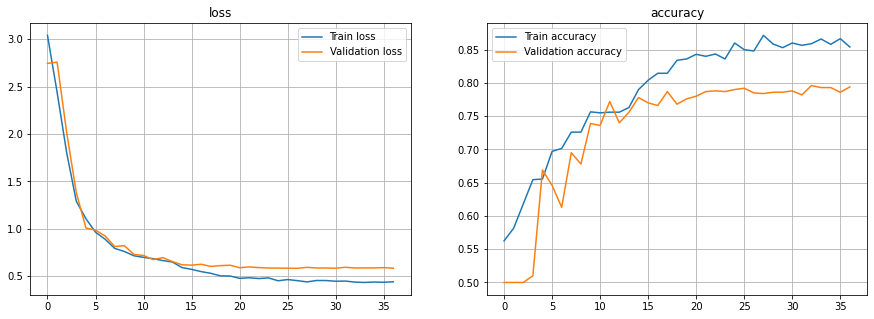

In [51]:
#display results 

show_history(history_v5)

# Use a pre-trained image classification model 

A good pre-trained image classification network should have high accuracy and should run fast. Another characteristic that shoud be taken into account but are is less important is the size of the model. In order to be as efficient as possible you should try to use a model that has high accuracy, runs fast and uses as few memory resources as possible. 

Based on these premises it is useful to check a comparison of pre-trained models that looks at their accuracy and speed when trying to classify the same data set. The following image from MathWorks block contains just that:

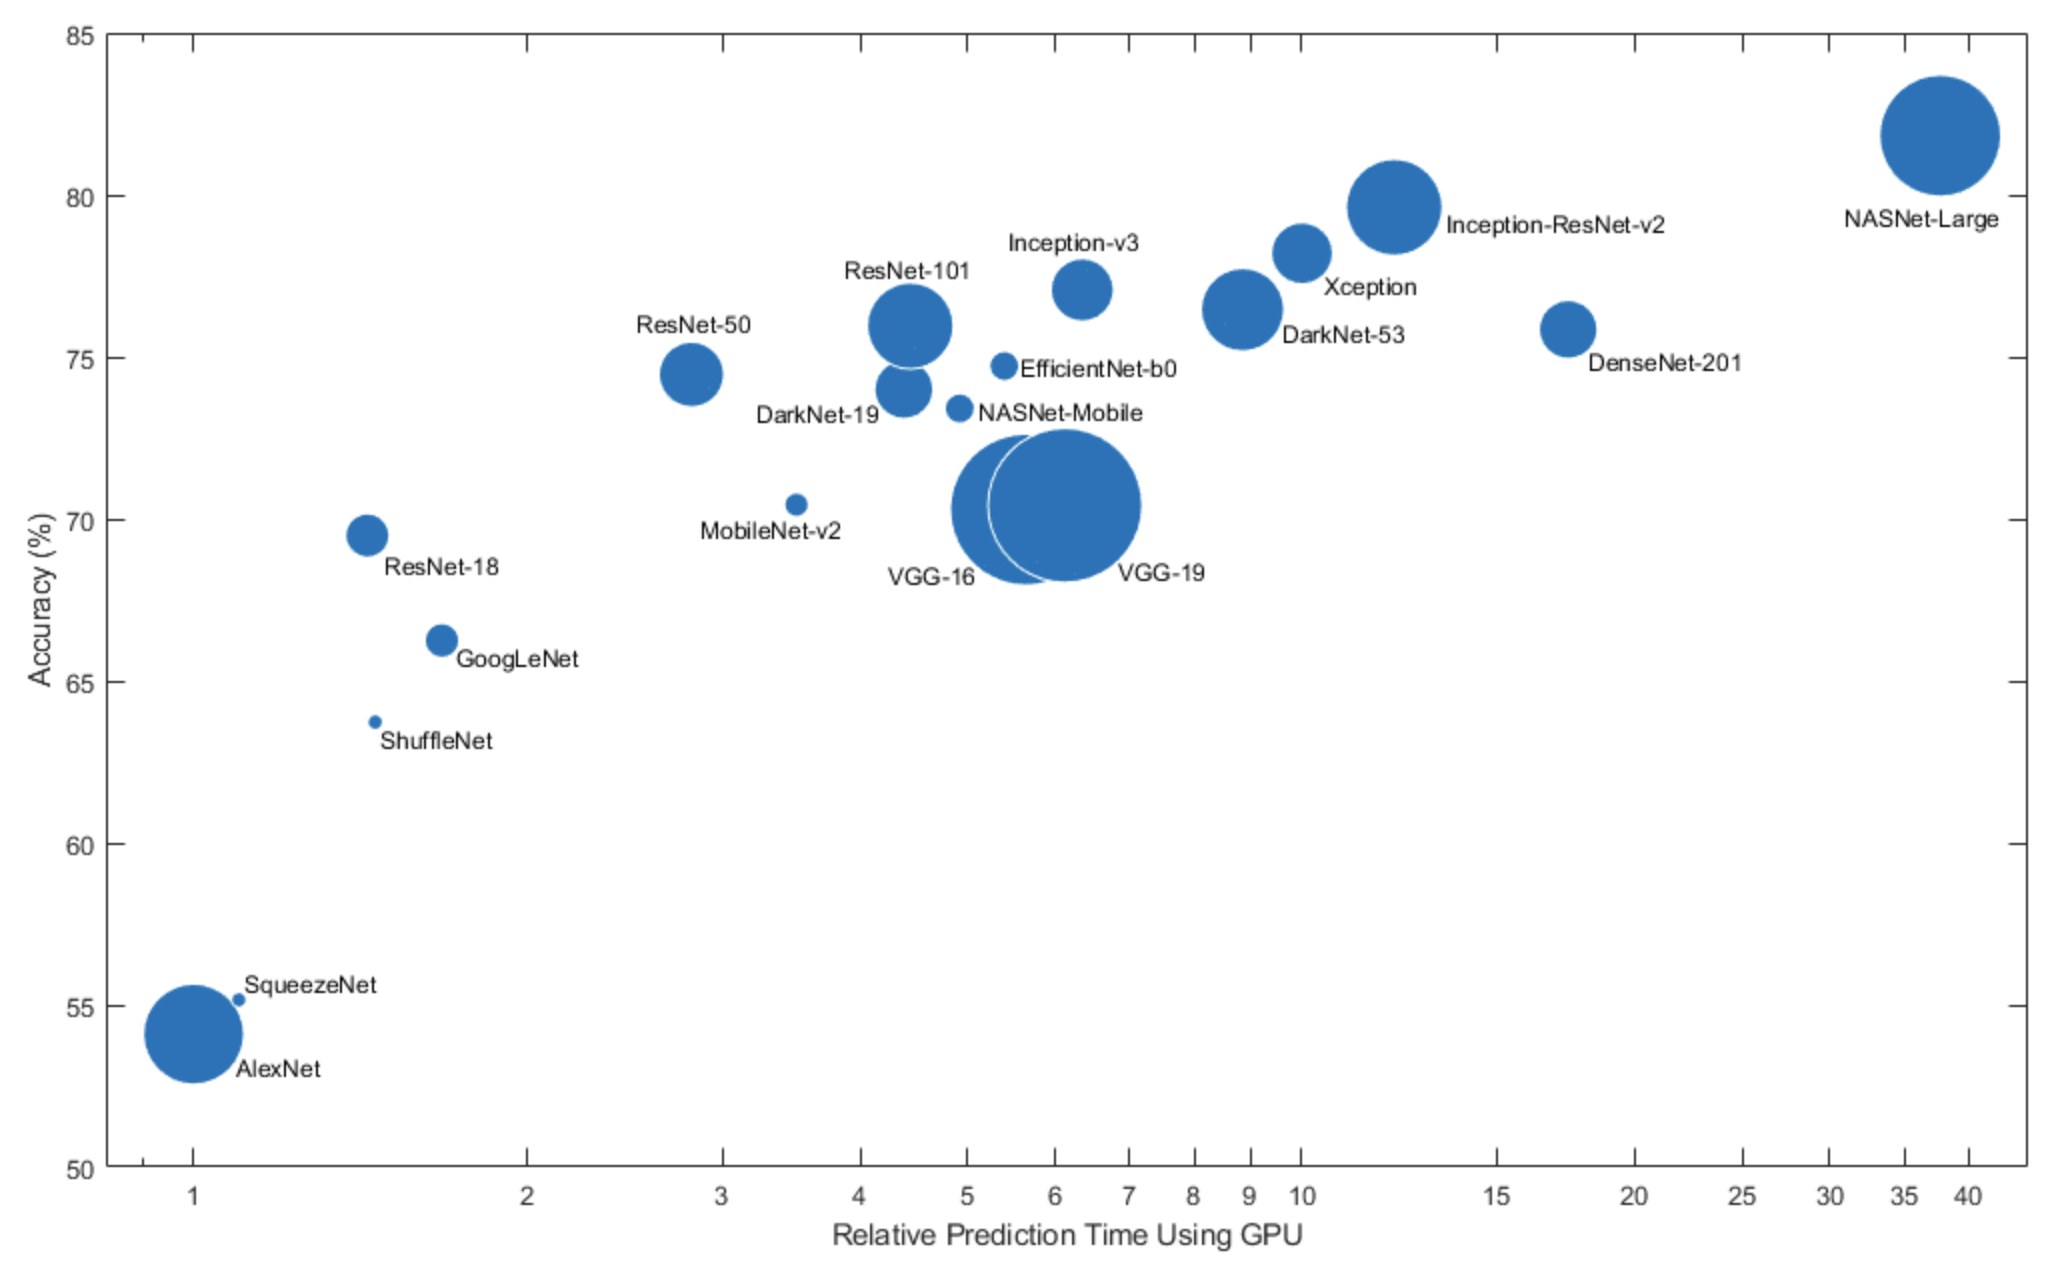

Image source: MathWorks (2022)

Based on this comparison it would be interesting to test any models that skew towards the top left, meaning models that have high accuracy and low prediction times. The ResNet-50 and the ResNet-101 look like interesting choices from this point of view.

In [52]:
#instantiate ResNet-101 from TensorFlow Keras

resnet = tf.keras.applications.resnet.ResNet101(
    include_top=False, #selecting "False" so that we can define our own input 
                       #shape, otherwise input has to be (224, 224, 3) 
    weights='imagenet',
    input_tensor=None,
    input_shape=(img_height,img_width, 3), #define our own input shape previosly used
    pooling='max',
    classes=2
)

In [53]:
#define data augmentation layer

data_augmentation = tf.keras.Sequential([
    #Data augmentation layers
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2,0.2), #height an width values
    tf.keras.layers.RandomContrast(0.2), #upper and lower bound for contrast changes
])

In [54]:
# convert images so that they can be passed to a CNN using resnet 
#will convert the input images from RGB to BGR, 
#then will zero-center each color channel with respect to the ImageNet dataset,
#without scaling.

preprocess_input = tf.keras.applications.resnet.preprocess_input

In [55]:
# create the base model using the pre-trained Resnet-101 model

base_model = tf.keras.applications.resnet.ResNet101(
    include_top=False, #selecting "False" so that we can define our own input 
                       #shape, otherwise input has to be (224, 224, 3) 
    weights='imagenet',
    input_tensor=None,
    input_shape=(img_height,img_width, 3), #define our own input shape previosly used
    pooling='max',
    classes=2
)

In [56]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(20, 2048)


In [57]:
#"freeze" convolutional base by setting trainable=False
#this prevents the model weights from being updated during training 

base_model.trainable = False

In [58]:
#see the summary of the model

base_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']     

In [59]:
# add the dense layer, batch normalisation, dropout and final prediction layer

dense_layer = tf.keras.layers.Dense(512, activation='relu')
batch_normalization = tf.keras.layers.BatchNormalization()
dropout = tf.keras.layers.Dropout(0.2)
prediction_layer = tf.keras.layers.Dense(2, activation="softmax")



In [60]:
# build the model combining all the layers 

inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = dense_layer(x)
x = batch_normalization(x)
x = dropout(x)
outputs = prediction_layer(x)
model_resnet = tf.keras.Model(inputs, outputs)

In [61]:
#compile model changing loss function to categorical crossentropy

model_resnet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])


In [62]:
#summary of the model 

model_resnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 dense_11 (Dense)            (None, 512)               1049088   
                                                             

In [63]:
#apply the same callbacks we applied before but changing the directory to save the model

callbacks = [earlystop, learning_rate_reduction,tf.keras.callbacks.ModelCheckpoint("./model_resnet_logs/save_at_{epoch}.h5")]

In [64]:
#fit the model 

history_resnet = model_resnet.fit(train_ds, 
                    steps_per_epoch=100, #samples / batch size
                    epochs=50,
                    validation_data=val_ds,
                    validation_steps=50, #samples / batch size
                    callbacks=callbacks
                    )

Epoch 1/50
100/100 [==============================] - 26s 184ms/step - loss: 0.1980 - accuracy: 0.9330 - val_loss: 0.0831 - val_accuracy: 0.9820 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 17s 167ms/step - loss: 0.1348 - accuracy: 0.9570 - val_loss: 0.0446 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - 17s 165ms/step - loss: 0.0937 - accuracy: 0.9675 - val_loss: 0.0325 - val_accuracy: 0.9910 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 17s 168ms/step - loss: 0.0959 - accuracy: 0.9675 - val_loss: 0.0662 - val_accuracy: 0.9790 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - ETA: 0s - loss: 0.0683 - accuracy: 0.9735
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
100/100 [==============================] - 17s 168ms/step - loss: 0.0683 - accuracy: 0.9735 - val_loss: 0.0589 - val_accuracy: 0.9830 - lr: 0.0010
Epoch 6/50
100/100 [=============================

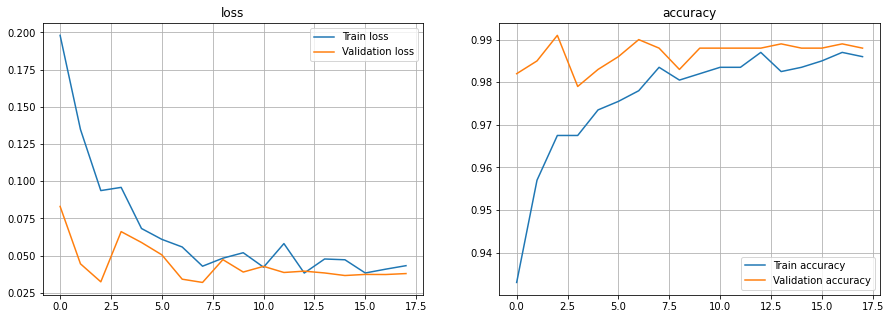

In [65]:
#display results 

show_history(history_resnet)

In [66]:
print("{:.2f}".format(history_resnet.history['val_accuracy'][-1]))

0.99


#Compare models and comment results

In [67]:
# Build a df to compare the accuracy of all models

model_v1_results = "{:.2f}".format(history_v1.history['val_accuracy'][-1])
model_v2_results = "{:.2f}".format(history_v2.history['val_accuracy'][-1])
model_v3_results = "{:.2f}".format(history_v3.history['val_accuracy'][-1])
model_v4_results = "{:.2f}".format(history_v4.history['val_accuracy'][-1])
model_v5_results = "{:.2f}".format(history_v5.history['val_accuracy'][-1])
model_resnet_results = "{:.2f}".format(history_resnet.history['val_accuracy'][-1])

models = [model_v1_results, model_v2_results, model_v3_results, 
          model_v4_results, model_v5_results, model_resnet_results]


#model v1 is a simple CNN 
#model v2 adds image augmentation and regularization parameters
#model v3 adds early stopping and learning rate reduction upon plateau
#model v4 adds more image augmentation layers
#model v5 reproduces v4 but using TF image processing libraries
#model_resnet uses the resnet-101 convolutional base

df_results = pd.DataFrame(models, columns=['Accuracy'], index = ['Model_v1','Model_v2', 'Model_v3', 'Model_v4', 'Model_v5', 'Model_ResNet-101'])

df_results

,Accuracy
Model_v1,0.70
Model_v2,0.75
Model_v3,0.82
Model_v4,0.81
Model_v5,0.79
Model_ResNet-101,0.99


The different additions to the model have generally improved model accuracy. We start with a base model that uses 4 convolutional neural four sets of Convolutional, Batch Normalization and MaxPooling layers. As mentioned in the comments of model v1 the number of filters in the convolutional layers grows as we progress through the network to allow the model to start capturing larger, simpler features and then refine them in smaller and more precise features. (Géron, A. 2019). 

The biggest problem with model v1 is overfitting. The model learns very well the featues of the training dataset but then doesn't generalise well then predicting the test dataset. That's why in model v2 we added image augmentation layers and regularisation parameters (the details of each technique are explained in model v2 comments). Both techniques are meant to reduce overfitting and allow the model to generalise better and that is visible in the 5% improvement we see in the model accuracy versus v1.

In model v3 we added early stopping which stops the learning process if the accuracy hasn't increased in n epochs. We also added learning rate reduction which allows us to reduce the learning rate if the model accuracy hasn't improved after n epochs. The addition of "learning rate reduction" has been key to improve the model accuracy even further. Reducing the learning rate when model accuracy has plateaued allows the algorithm to optimise the loss function making smaller changes from that point onwards thus allowing it to find more optimal weights that improve the accuracy further. The effect of this is visible in the improvement of accuracy which jumps up 7% compared to model v2. 

Model v4 adds a few more image augmentation layers which don't bring any improvement to the model accuracy. The 1% decrease vs model v3 can be attributed to fluctuations in accuracy between epochs. 

Model v5 applies the exact same CNN architecture as model v4, what changes here is how the images are pre-processed (instead of being pre-processed manually using the function written at the beginning, they are pre-processed using TensorFlow's Image pre-processing library). Again, the variation in accuracy vs model v4 can be attributed to small variations between epochs. 

The model that clearly is at different level than the rest in terms of accuracy is the one using ResNet-101 convolutional base. From the first epoch this model achieves a validation accuracy that is higher than any of the previous models, and achieves an impressive 99% accuracy on the validation dataset. ResNet-101 is a CNN that is 101 layers deep and has been pre-trained using more than a million images from the ImageNet database. The depth of convolutional layers in ResNet-101 allows the model to gain a lot of accuracy compared to previously used models such as VGG. This stems from the fact that deeper networks can learn more complex, non-linear functions. (He et al, 2015)

#References

References:

* Amini, A. (2020) MIT 6.S191 (2020): Convolutional Neural Networks. https://www.youtube.com/watch?v=iaSUYvmCekI.

* Starmer, J. (2021) Neural Networks Part 8: Image Classification with Convolutional Neural Networks. https://www.youtube.com/watch?v=HGwBXDKFk9I.

* Giordano, D. (2020) 7 tips to choose the best optimizer. https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e.

* Goodfellow, I., Bengio, Y. & Courville, A. (2016) Deep Learning (Adaptive Computation and Machine Learning series). MIT Press.

* Brownlee, J. (n.d.) How to Configure the Number of Layers and Nodes in a Neural Network. https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/.

* Géron, A. (2019) Chapter 14. Deep Computer Vision Using Convolutional Neural Networks. In: Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition. O’Reilly Media. p. https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch14.html#idm45022139960744.

* Bjorck, J., Gomes, C. & Selman, B. (2018) Understanding Batch Normalization. https://arxiv.org/abs/1806.02375v1.

* He, K., Zhang, X., Ren, S. & Sun, J. (2015) Deep Residual Learning for Image Recognition. https://arxiv.org/abs/1512.03385.

* MathWorks (2022) Pretrained Deep Neural Networks. MathWorks. https://www.mathworks.com/help/deeplearning/ug/pretrained-convolutional-neural-networks.html.








